
* [ssdlite320_mobilenet_v3_large](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.ssdlite320_mobilenet_v3_large.html)
* [Real Time Inference on Raspberry Pi 4](https://pytorch.org/tutorials/intermediate/realtime_rpi.html)



In [1]:
%reload_ext autoreload
%autoreload 2

In [8]:
import io

from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import Layout, Widget
import numpy as np
from PIL import Image
from torchvision import transforms

In [3]:
# Webcam settings
cam = CameraStream(
    constraints={
        "facing_mode": "user",
        "audio": False,
        "video": {"width": 320, "height": 320},
    },
    layout=Layout(width="320"),
)
image_recorder = ImageRecorder(stream=cam)
image_recorder
# Image recorder for taking a snapshot
# w_imrecorder = ImageRecorder(
#     format="jpg", stream=w_cam, layout=Layout(padding="0 0 0 100px")
# )

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

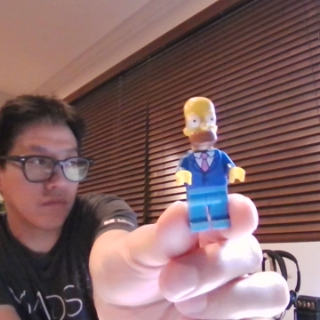

In [14]:
# Get the image (RGBA) and convert to RGB
im = Image.open(io.BytesIO(image_recorder.image.value)).convert("RGB")
im

In [5]:
# Turn off cam
Widget.close_all()

In [23]:
np.array(im).shape

(320, 320, 3)

In [21]:
preprocess = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(im)
# The model can handle multiple images simultaneously so we need to add an
# empty dimension for the batch.
# [320, 320, 3] -> [1, 3, 320, 320]
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 320, 320])

In [27]:
# import torch
# torch.backends.quantized.engine = 'qnnpack'

from torchvision import models

# Quantized (int8) model
# Quantized MobileNetV3-Large is about the same speed and size as MobileNetv3-Small, yet it has higher accuracy.
net = models.quantization.mobilenet_v3_large(pretrained=True, quantize=True)


/home/junkimin/miniconda3/envs/pi-eye/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/junkimin/miniconda3/envs/pi-eye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_QuantizedWeights.IMAGENET1K_QNNPACK_V1`. You can also use `weights=MobileNet_V3_Large_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/quantized/mobilenet_v3_large_qnnpack-5bcacf28.pth" to /home/junkimin/.cache/torch/hub/checkpoints/mobilenet_v3_large_qnnpack-5bcacf28.pth
100.0%
/home/junkimin/miniconda3/envs/pi-eye/lib/python3.10/site-packages/torch/ao/quanti

In [29]:
import torch
# torch.set_num_threads(2)

# Convert into jit (graph mode). In eager mode, operators in a model are immediately executed as they are encountered. In contrast, in graph mode, operators are first synthesized into a graph, which will then be compiled and executed as a whole
# This reduce overhead
net = torch.jit.script(net)

In [30]:
# model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
# torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval scrip
with torch.no_grad():
    output = net(input_batch)

In [32]:
output.shape

torch.Size([1, 1000])

In [33]:
with open("imagenet_class_labels.txt") as f:
    idx_to_label = eval(f.read())

In [35]:
top = list(enumerate(output[0].softmax(dim=0)))
top.sort(key=lambda x: x[1], reverse=True)
for idx, val in top[:10]:
    print(f"{val.item()*100:.2f}% {idx_to_label[idx]}")

11.78% balloon
11.78% nipple
9.80% candle, taper, wax light
9.80% ping-pong ball
6.77% hair spray
6.77% water bottle
5.63% lighter, light, igniter, ignitor
5.63% sunscreen, sunblock, sun blocker
5.63% ice lolly, lolly, lollipop, popsicle
3.24% cocktail shaker


In [39]:
# Load object detection model. TODO: Need to quantize manually
net = models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)

/home/junkimin/miniconda3/envs/pi-eye/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/junkimin/miniconda3/envs/pi-eye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /home/junkimin/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100.0%


In [43]:
coco_labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_labels), 3))

In [41]:
net = net.eval()

In [44]:
preprocess_no_normalize = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
])

In [45]:
input_tensor = preprocess_no_normalize(im)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    outputs = net(input_batch)

In [52]:
pred_scores = outputs[0]['scores'].numpy()  # .detach().cpu().numpy()
pred_bboxes = outputs[0]['boxes'].numpy()  # .detach().cpu().numpy()

In [54]:
detection_threshold = 0.5

# get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
labels = outputs[0]['labels'][:len(boxes)]
# get all the predicited class names
pred_classes = [coco_labels[i] for i in labels.cpu().numpy()]

In [55]:
pred_classes

['person']

In [78]:
import cv2
def draw_boxes(boxes, classes, labels, image):
    """
    Draws the bounding box around a detected object.
    """
    image = np.array(image)  # cv2.cvtColor(np.asarray(image))  # , cv2.COLOR_RGB2BGR
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [77]:
type(im)

PIL.Image.Image

In [79]:
output_img = draw_boxes(boxes=boxes, classes=pred_classes, labels=labels, image=im)


In [80]:
output_img.shape

(320, 320, 3)

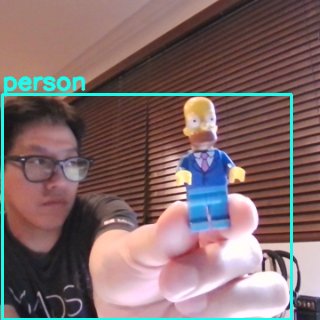

In [81]:
Image.fromarray(output_img)